In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt


In [7]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Paths
original_dataset_dir = '/content/drive/MyDrive/Mammogram/Mammogram'
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create new directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Categories
categories = ['Benign', 'Malignant']

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    category_dir = os.path.join(original_dataset_dir, category)
    images = os.listdir(category_dir)
    random.shuffle(images)

    # Split the images into 80% training and 20% validation
    train_split = int(0.8 * len(images))
    train_images = images[:train_split]
    val_images = images[train_split:]

    for image in train_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(train_dir, category, image)
        shutil.copyfile(src, dst)

    for image in val_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(val_dir, category, image)
        shutil.copyfile(src, dst)

print("Dataset restructured successfully.")

Dataset restructured successfully.


In [3]:
# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Only rescaling for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',

)

validation_generator = val_datagen.flow_from_directory(
    'dataset/validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)


Found 8032 images belonging to 2 classes.
Found 2008 images belonging to 2 classes.


Batch shape: (32, 150, 150, 1)
Labels shape: (32,)


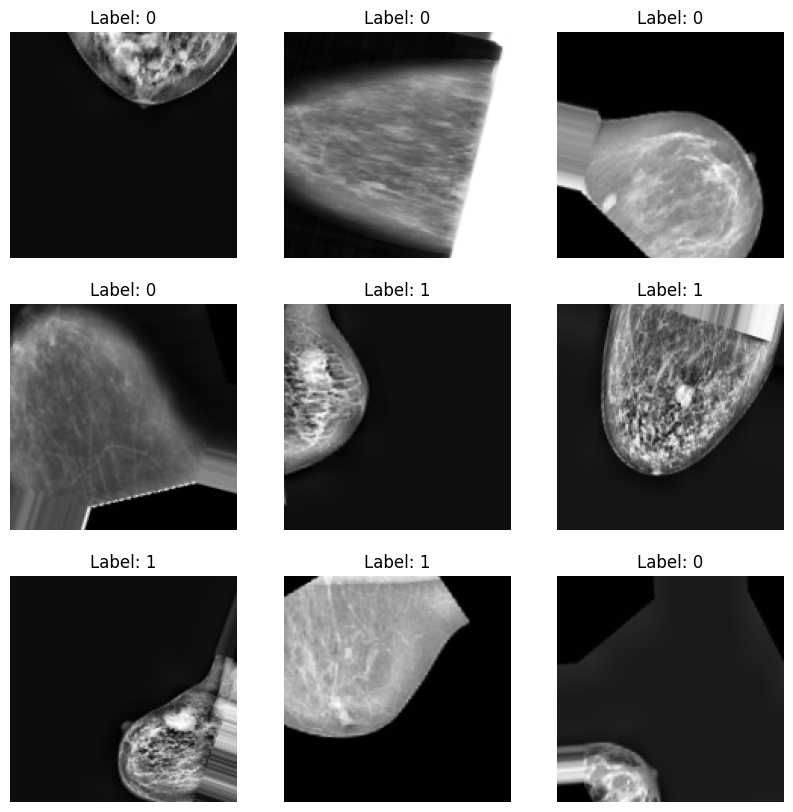

In [5]:
# Fetch a batch of images and labels from the training generator
x_batch, y_batch = next(train_generator)

# Check the shapes of the batch
print(f"Batch shape: {x_batch.shape}")
print(f"Labels shape: {y_batch.shape}")

# Plot the images in the batch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(min(len(x_batch), 9)):  # Plot up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i].reshape(150, 150), cmap='gray')
    plt.title(f'Label: {int(y_batch[i])}')
    plt.axis('off')
plt.show()


Batch 1 - x_batch shape: (32, 150, 150, 1), y_batch shape: (32,)


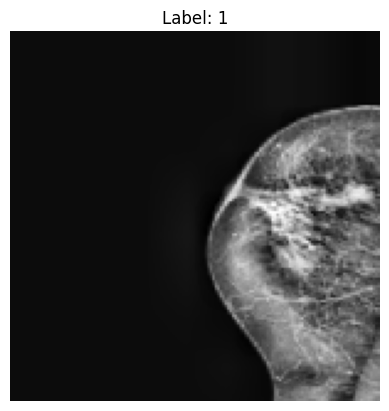

Batch 2 - x_batch shape: (32, 150, 150, 1), y_batch shape: (32,)


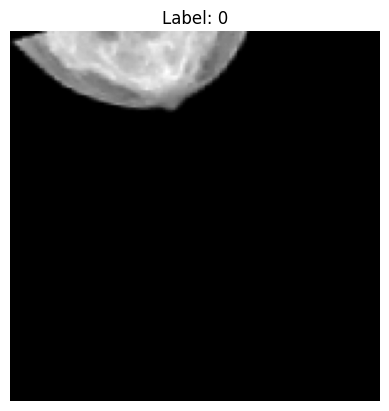

Batch 3 - x_batch shape: (32, 150, 150, 1), y_batch shape: (32,)


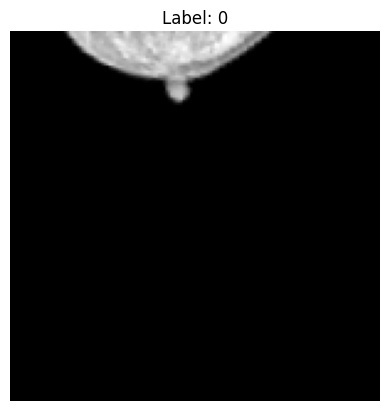

In [6]:
# Inspect multiple batches from the training generator
for i in range(3):  # Check 3 batches
    x_batch, y_batch = next(train_generator)
    print(f"Batch {i+1} - x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")

    # Plot the first image in each batch
    plt.figure()
    plt.imshow(x_batch[0].reshape(150, 150), cmap='gray')
    plt.title(f'Label: {int(y_batch[0])}')
    plt.axis('off')
    plt.show()


In [7]:
# Fetch a few batches and check the class distribution
num_batches = 5
labels = []

for _ in range(num_batches):
    _, y_batch = next(train_generator)
    labels.extend(y_batch)

labels = np.array(labels)
print(f"Class distribution in {num_batches} batches: {np.bincount(labels.astype(int))}")


Class distribution in 5 batches: [82 78]


In [8]:
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Steps per epoch: 251
Validation steps: 62


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should only be rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    '/content/dataset/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Load DenseNet121 without the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_densenet_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)



Found 8032 images belonging to 2 classes.
Found 2008 images belonging to 2 classes.


Epoch 1/10
251/251 [==============================] - 138s 318ms/step - loss: 0.6019 - accuracy: 0.6919 - val_loss: 0.4951 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 2/10
251/251 [==============================] - 77s 306ms/step - loss: 0.5023 - accuracy: 0.7414 - val_loss: 1.5903 - val_accuracy: 0.5554 - lr: 0.0010
Epoch 3/10
251/251 [==============================] - 78s 310ms/step - loss: 0.4995 - accuracy: 0.7489 - val_loss: 0.4603 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 4/10
251/251 [==============================] - 78s 311ms/step - loss: 0.4617 - accuracy: 0.7666 - val_loss: 0.5656 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 5/10
251/251 [==============================] - 79s 316ms/step - loss: 0.5034 - accuracy: 0.7536 - val_loss: 43.3857 - val_accuracy: 0.5549 - lr: 0.0010
Epoch 6/10
251/251 [==============================] - 78s 312ms/step - loss: 0.4495 - accuracy: 0.7754 - val_loss: 0.5541 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 7/10
251/251 [==============================

In [27]:
# prompt: print validation accuracy

val_accuracy = history.history['val_accuracy'][-1] * 100
print(f"Validation accuracy: {val_accuracy:.2f}%")


Validation accuracy: 84.98%


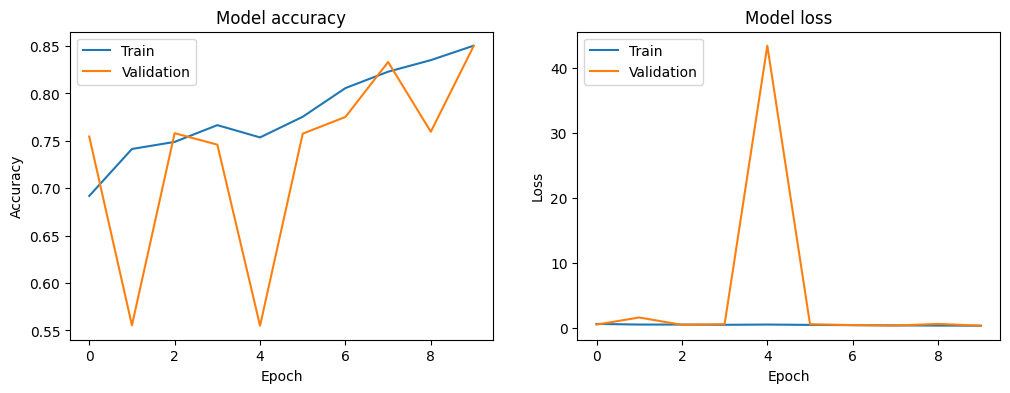

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

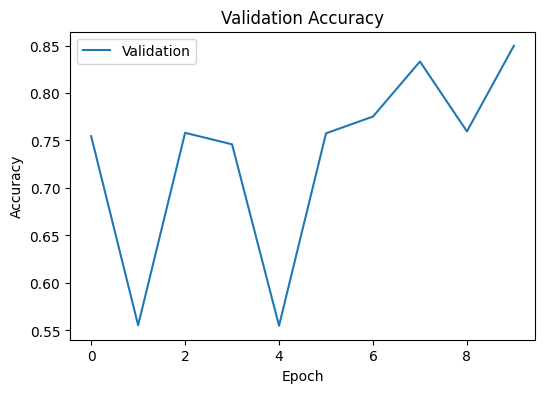

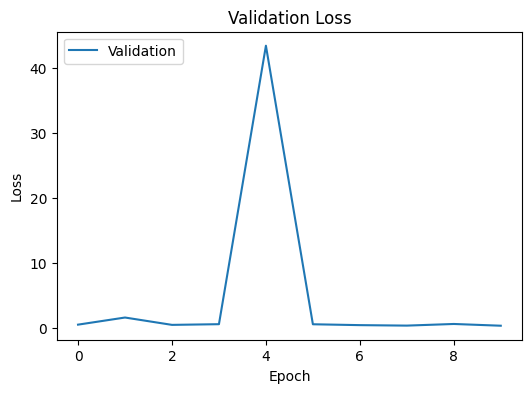

In [18]:
import matplotlib.pyplot as plt

# Plot validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()


63/63 [==============================] - 5s 57ms/step


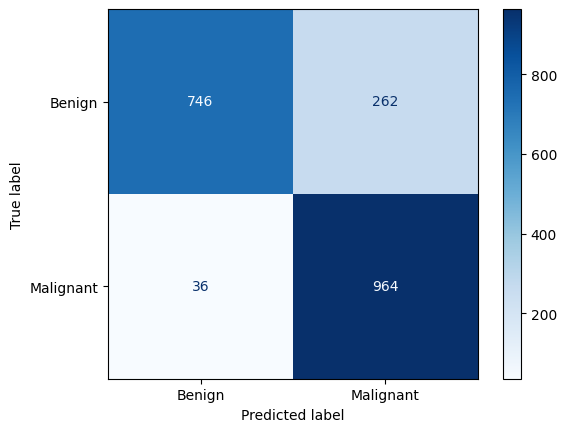

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the validation generator is at the beginning
validation_generator.reset()

# Get true labels and predict on the validation data
true_labels = validation_generator.classes
# Predict on the entire validation set, not just a subset
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [28]:
# prompt: print classification report

from sklearn.metrics import classification_report

# Ensure the validation generator is at the beginning
validation_generator.reset()

# Get true labels and predict on the validation data
true_labels = validation_generator.classes
# Predict on the entire validation set, not just a subset
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Generate the classification report
report = classification_report(true_labels, predicted_classes)

# Print the classification report
print(report)


63/63 [==============================] - 5s 55ms/step
              precision    recall  f1-score   support

           0       0.95      0.74      0.83      1008
           1       0.79      0.96      0.87      1000

    accuracy                           0.85      2008
   macro avg       0.87      0.85      0.85      2008
weighted avg       0.87      0.85      0.85      2008



In [20]:
# prompt: saving model

model.save('/content/drive/MyDrive/mammogram_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
# Import the necessary module for file uploads in Colab
from google.colab import files

# Load the saved model
model = tf.keras.models.load_model('/content/best_inceptionv3_model._99%h5')

# Upload an image
uploaded = files.upload()

# Preprocess the image
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict the class
prediction = model.predict(img_array)

# Print the prediction
if prediction[0][0] > 0.5:
    print("Malignant")
else:
    print("Benign")

Saving malignant998.png to malignant998 (1).png
1/1 [==============================] - 1s 1s/step
Malignant


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should only be rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    '/content/dataset/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Load DenseNet121 without the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_densenet_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)



Found 8032 images belonging to 2 classes.
Found 2008 images belonging to 2 classes.


Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 0.5775 - accuracy: 0.7051

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 139s 318ms/step - loss: 0.5775 - accuracy: 0.7051 - val_loss: 0.6857 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 2/20
251/251 [==============================] - 78s 312ms/step - loss: 0.4617 - accuracy: 0.7603 - val_loss: 1.2288 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 3/20
251/251 [==============================] - 77s 305ms/step - loss: 0.4296 - accuracy: 0.7754 - val_loss: 0.6950 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 4/20
251/251 [==============================] - 77s 306ms/step - loss: 0.3868 - accuracy: 0.8008 - val_loss: 0.7835 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 5/20
251/251 [==============================] - 78s 309ms/step - loss: 0.3169 - accuracy: 0.8508 - val_loss: 0.2734 - val_accuracy: 0.8710 - lr: 2.0000e-04
Epoch 6/20
251/251 [==============================] - 76s 303ms/step - loss: 0.2593 - accuracy: 0.8782 - val_loss: 0.3226 - val_accuracy: 0.8377 - lr: 2.0000e-04
Epoch 7/20
251/251 [==============================] - 

In [30]:
# prompt: print validation accuracy

val_accuracy = history.history['val_accuracy'][-1] * 100
print(f"Validation accuracy: {val_accuracy:.2f}%")


Validation accuracy: 99.75%


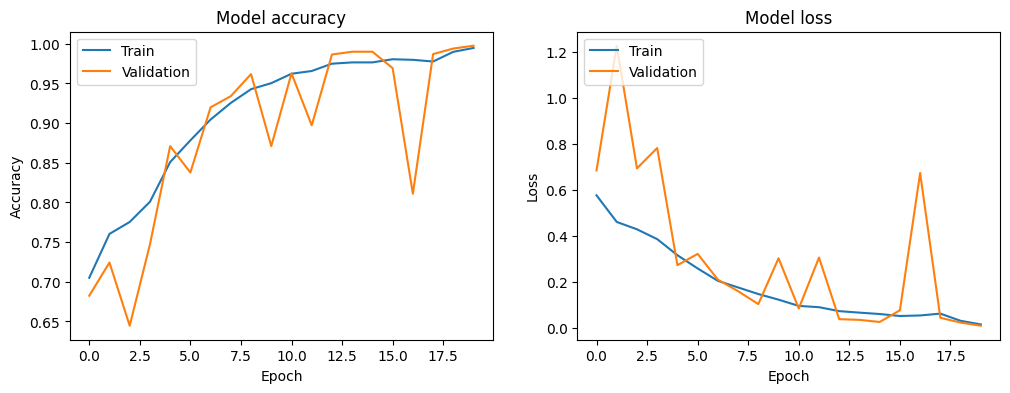

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

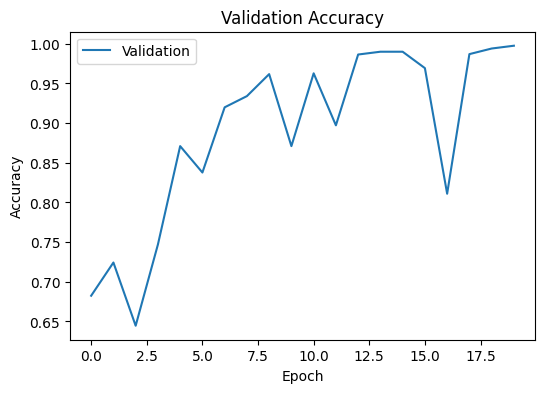

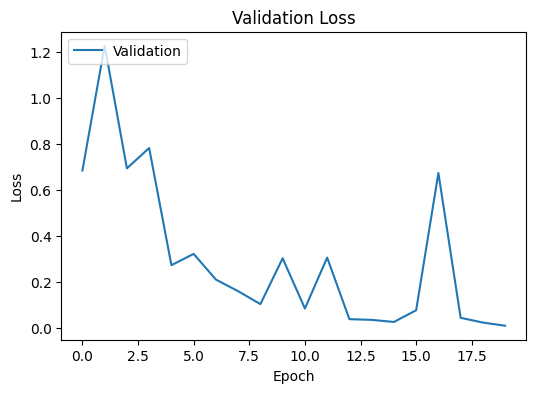

In [32]:
import matplotlib.pyplot as plt

# Plot validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()


63/63 [==============================] - 5s 55ms/step


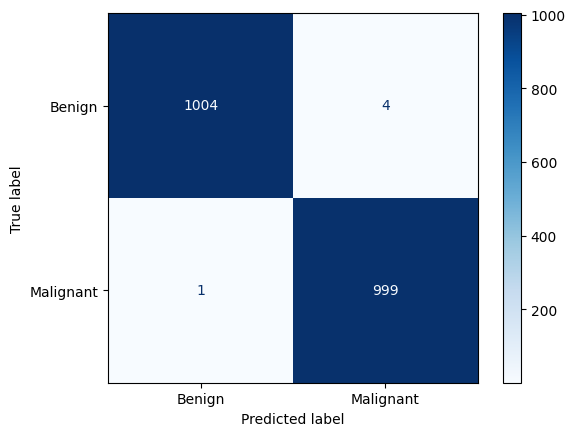

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the validation generator is at the beginning
validation_generator.reset()

# Get true labels and predict on the validation data
true_labels = validation_generator.classes
# Predict on the entire validation set, not just a subset
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [34]:
# prompt: print classification report

from sklearn.metrics import classification_report

# Ensure the validation generator is at the beginning
validation_generator.reset()

# Get true labels and predict on the validation data
true_labels = validation_generator.classes
# Predict on the entire validation set, not just a subset
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Generate the classification report
report = classification_report(true_labels, predicted_classes)

# Print the classification report
print(report)


63/63 [==============================] - 3s 53ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1008
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2008
   macro avg       1.00      1.00      1.00      2008
weighted avg       1.00      1.00      1.00      2008



In [9]:
from PIL import Image
import os

def verify_images(directory):
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                img = Image.open(file_path)  # Attempt to open the image file
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                print(f"Corrupt image found and removed: {file_path}")
                os.remove(file_path)  # Remove corrupt image

# Check both train and validation directories
verify_images('/content/dataset/train')
verify_images('/content/dataset/validation')


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should only be rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    '/content/dataset/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Load InceptionV3 without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_inceptionv3_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Found 8032 images belonging to 2 classes.
Found 2008 images belonging to 2 classes.


Epoch 1/15
251/251 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.7199

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 106s 281ms/step - loss: 0.5614 - accuracy: 0.7199 - val_loss: 3.2394 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 2/15
251/251 [==============================] - 69s 275ms/step - loss: 0.4580 - accuracy: 0.7658 - val_loss: 1.3320 - val_accuracy: 0.7611 - lr: 0.0010
Epoch 3/15
251/251 [==============================] - 69s 275ms/step - loss: 0.4093 - accuracy: 0.8024 - val_loss: 1.5284 - val_accuracy: 0.7495 - lr: 0.0010
Epoch 4/15
251/251 [==============================] - 71s 280ms/step - loss: 0.3621 - accuracy: 0.8293 - val_loss: 0.3561 - val_accuracy: 0.7999 - lr: 0.0010
Epoch 5/15
251/251 [==============================] - 72s 288ms/step - loss: 0.3496 - accuracy: 0.8398 - val_loss: 0.2941 - val_accuracy: 0.8508 - lr: 0.0010
Epoch 6/15
251/251 [==============================] - 66s 264ms/step - loss: 0.2880 - accuracy: 0.8716 - val_loss: 0.4210 - val_accuracy: 0.8236 - lr: 0.0010
Epoch 7/15
251/251 [==============================] - 67s 268m

In [11]:
# prompt: print validation accuracy

val_accuracy = history.history['val_accuracy'][-1] * 100
print(f"Validation accuracy: {val_accuracy:.2f}%")


Validation accuracy: 99.55%


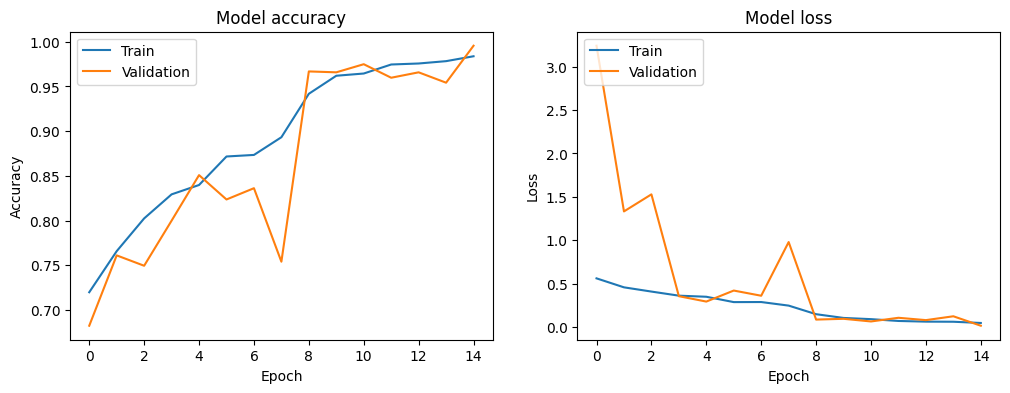

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

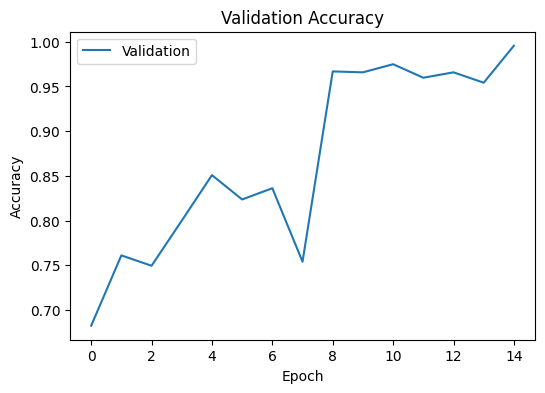

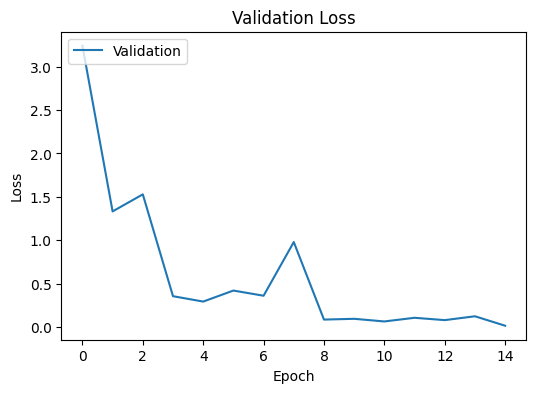

In [13]:
import matplotlib.pyplot as plt

# Plot validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

63/63 [==============================] - 12s 140ms/step


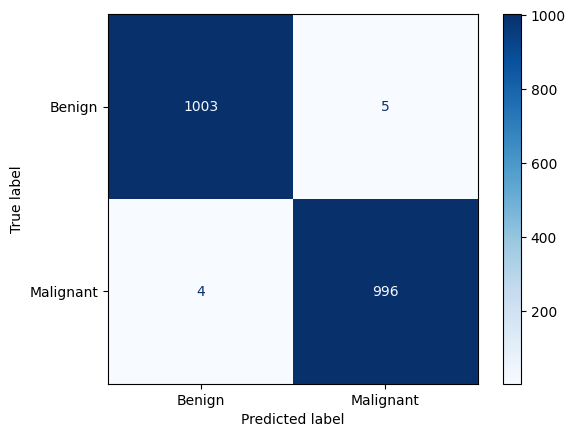

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the validation generator is at the beginning
validation_generator.reset()

# Get true labels and predict on the validation data
true_labels = validation_generator.classes
# Predict on the entire validation set, not just a subset
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [17]:
# prompt: print classification report

from sklearn.metrics import classification_report

# Ensure the validation generator is at the beginning
validation_generator.reset()

# Get true labels and predict on the validation data
true_labels = validation_generator.classes
# Predict on the entire validation set, not just a subset
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# Generate the classification report
report = classification_report(true_labels, predicted_classes)

# Print the classification report
print(report)

63/63 [==============================] - 5s 74ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1008
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2008
   macro avg       1.00      1.00      1.00      2008
weighted avg       1.00      1.00      1.00      2008



In [15]:
# prompt: saving model

model.save('/content/drive/MyDrive/inception_model_99%.h5')